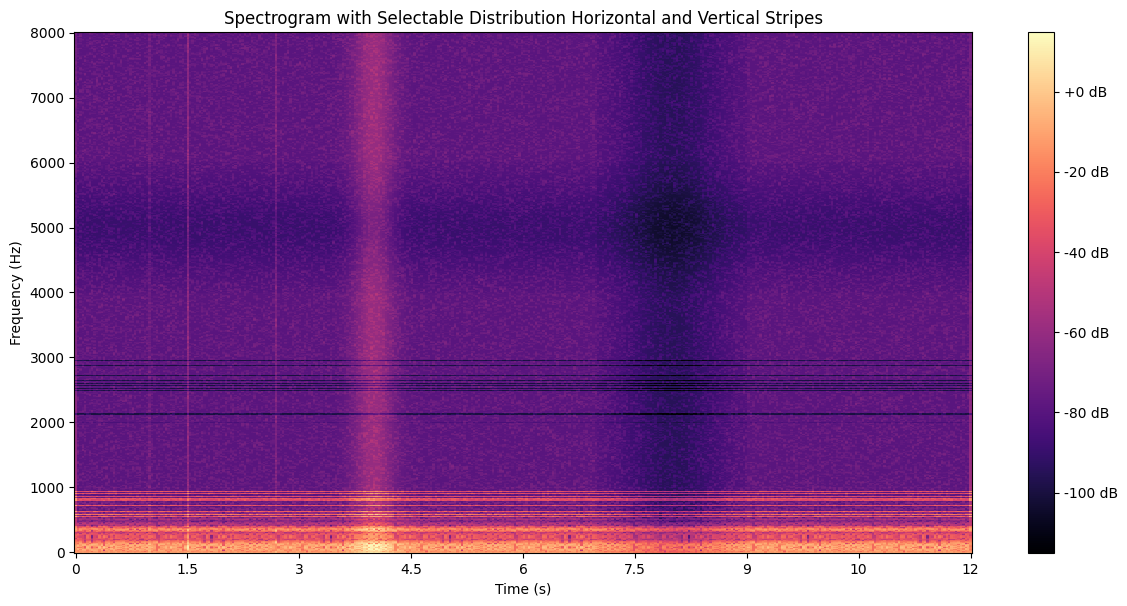

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import random

def _generate_gaussian_noise(length, params):
    """Generate Gaussian noise."""
    mean = params.get('mean', 0.0)
    std = params.get('std', 1.0)
    return np.random.normal(mean, std, length)

def _generate_linear_noise(length, params):
    """Generate linear noise (not used as per instructions)."""
    low = params.get('low', -1.0)
    high = params.get('high', 1.0)
    return np.linspace(low, high, length)

class SpectrogramModifier:
    def __init__(self, sample_rate=16000, n_fft=256, hop_length=None, 
                 noise_strength=0.1, noise_params=None):
        """Spectrogram creation and modification class with Gaussian noise."""
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length if hop_length is not None else n_fft // 4
        self.noise_strength = noise_strength
        self.noise_params = noise_params if noise_params else {}
        self.signal = None
        self.signal_with_noise = None
        self.S_db = None

    def generate_noise(self, signal):
        """Add Gaussian noise to the signal."""
        length = len(signal)
        noise = _generate_gaussian_noise(length, self.noise_params)
        return signal + noise * self.noise_strength

    def compute_spectrogram(self, signal):
        """Compute dB spectrogram of the input signal."""
        self.signal = signal
        self.signal_with_noise = self.generate_noise(signal)
        S = np.abs(librosa.stft(self.signal_with_noise, n_fft=self.n_fft, hop_length=self.hop_length, window='hann'))
        self.S_db = librosa.amplitude_to_db(S, ref=np.max)
        return self.S_db

    def _get_freqs(self):
        """Get frequency values for the spectrogram."""
        return np.linspace(0, self.sample_rate / 2, self.S_db.shape[0])

    def _get_times(self):
        """Get time values for the spectrogram."""
        return librosa.frames_to_time(np.arange(self.S_db.shape[1]), sr=self.sample_rate, hop_length=self.hop_length)

    def _get_gaussian_distribution(self, values, params):
        """Generate Gaussian distribution based on values."""
        sigma = params.get('sigma', 5)
        center = (values.min() + values.max()) / 2
        dist = np.exp(-0.5 * ((values - center) / sigma) ** 2)
        dist /= dist.max()
        return dist

    def add_patterns(self, pattern_proportions, pattern_params, num_patterns):
        """
        Add horizontal and vertical Gaussian patterns based on specified proportions and parameters.

        :param pattern_proportions: Dict specifying the proportion of each pattern type.
                                    Example: {"horizontal_line": 1, "vertical_line": 9}
        :param pattern_params: Dict containing parameters for patterns.
                               Should include ranges and strength settings.
                               Example:
                               {
                                   "horizontal_line_range": {"freq_min": 300, "freq_max": 6000},
                                   "vertical_line_range": {"time_min": 0.5, "time_max": 11.5},
                                   "horizontal_strength_db": {"min": 5, "max": 15},
                                   "vertical_strength_db": {"min": 5, "max": 15}
                               }
        :param num_patterns: Total number of patterns to add.
        """
        if self.S_db is None:
            raise ValueError("compute_spectrogram() must be called before adding patterns.")

        S_db_modified = self.S_db.copy()
        freqs = self._get_freqs()
        times = self._get_times()

        # Calculate total proportion
        total_prop = sum(pattern_proportions.values())

        # Normalize proportions to probabilities
        pattern_types = list(pattern_proportions.keys())
        pattern_weights = [pattern_proportions[ptype] / total_prop for ptype in pattern_types]

        for _ in range(num_patterns):
            # Select pattern type based on proportions
            pattern_type = random.choices(pattern_types, weights=pattern_weights, k=1)[0]

            if pattern_type == 'horizontal_line':
                # Random frequency within range
                freq_min = pattern_params['horizontal_line_range']['freq_min']
                freq_max = pattern_params['horizontal_line_range']['freq_max']
                freq = random.uniform(freq_min, freq_max)
                freq_idx = np.argmin(np.abs(freqs - freq))

                # Random strength
                strength_min = pattern_params['horizontal_strength_db']['min']
                strength_max = pattern_params['horizontal_strength_db']['max']
                strength_dB = random.uniform(strength_min, strength_max)

                # Add Gaussian distribution around the frequency
                sigma = pattern_params.get('horizontal_sigma', 50)
                dist = self._get_gaussian_distribution(freqs, {'sigma': sigma})
                S_db_modified += strength_dB * dist[:, np.newaxis]

            elif pattern_type == 'vertical_line':
                # Random time within range
                time_min = pattern_params['vertical_line_range']['time_min']
                time_max = pattern_params['vertical_line_range']['time_max']
                time = random.uniform(time_min, time_max)
                time_idx = np.argmin(np.abs(times - time))

                # Random strength
                strength_min = pattern_params['vertical_strength_db']['min']
                strength_max = pattern_params['vertical_strength_db']['max']
                strength_dB = random.uniform(strength_min, strength_max)

                # Add Gaussian distribution around the time
                sigma = pattern_params.get('vertical_sigma', 0.2)
                # Convert sigma from seconds to frames
                sigma_frames = sigma / (times[1] - times[0]) if len(times) > 1 else 1
                dist = self._get_gaussian_distribution(np.arange(len(times)), {
                    'sigma': sigma_frames
                })
                S_db_modified += strength_dB * dist[np.newaxis, :]

        # Normalize to prevent overflow
        self.S_db = S_db_modified
        return self.S_db

    def scale_spectrogram(self, scaling_factor=1.0):
        """Scale the entire spectrogram by a scaling factor."""
        if self.S_db is None:
            raise ValueError("compute_spectrogram() must be called before scaling.")
        self.S_db = self.S_db * scaling_factor
        return self.S_db

    def plot_spectrogram(self, show_labels=True, colormap='magma', title='Spectrogram'):
        """Visualize the spectrogram."""
        if self.S_db is None:
            raise ValueError("compute_spectrogram() must be called before plotting.")
        fig, ax = plt.subplots(figsize=(12, 6))
        img = librosa.display.specshow(
            self.S_db,
            sr=self.sample_rate,
            hop_length=self.hop_length,
            x_axis='time',
            y_axis='linear',
            ax=ax,
            cmap=colormap
        )
        if show_labels:
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_title(title)
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
        else:
            ax.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0.5)
        return fig, ax

# ==================== Usage Example ====================

if __name__ == "__main__":
    # Parameters for spectrogram
    sample_rate = 16000
    duration = 12  # seconds
    n_samples = sample_rate * duration
    np.random.seed(42)

    # Generate base Gaussian signal
    signal = np.random.normal(-80, 1, n_samples)  # base Gaussian noise

    # Initialize SpectrogramModifier with Gaussian noise
    spectro_mod = SpectrogramModifier(
        sample_rate=sample_rate, 
        n_fft=1024, 
        hop_length=512, 
        noise_strength=600,  # Adjusted for visibility
        noise_params={'mean': -80, 'std': 1.0}
    )

    # Compute initial spectrogram
    S_db = spectro_mod.compute_spectrogram(signal)

    # Define pattern proportions
    pattern_proportions = {
        "horizontal_line": 1,  # Represents 10% probability
        "vertical_line": 9     # Represents 90% probability
    }

    # Define pattern parameters with ranges and strengths
    pattern_params = {
        "horizontal_line_range": {"freq_min": 300, "freq_max": 6000},  # Hz
        "vertical_line_range": {"time_min": 0.5, "time_max": 11.5},    # seconds
        "horizontal_strength_db": {"min": 5, "max": 15},              # dB
        "vertical_strength_db": {"min": 5, "max": 15},                # dB
        "horizontal_sigma": 50,    # Frequency spread
        "vertical_sigma": 0.2       # Time spread in seconds
    }

    # Total number of patterns to add
    total_patterns = 50

    # Add random patterns based on proportions and parameters
    spectro_mod.add_patterns(
        pattern_proportions=pattern_proportions,
        pattern_params=pattern_params,
        num_patterns=total_patterns
    )

    # Scale spectrogram if needed (optional)
    spectro_mod.scale_spectrogram(1.0)

    # Plot the modified spectrogram
    fig, ax = spectro_mod.plot_spectrogram(
        show_labels=True,
        colormap='magma',
        title='Spectrogram with Gaussian Distributed Horizontal and Vertical Stripes'
    )
    plt.show()
